In [ ]:
!pip install tensorflow
!pip install statsmodels
!pip install numpy
!pip install scikit-learn
!pip install seaborn
!pip install matplotlib
!pip install pandas
!pip install yfinance
!pip install pandas_datareader
!pip install pandas_ta
!pip install projectpro

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.1/115.1 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pandas_ta: filename=pandas_ta-0.3.14b0-py3-none-any.whl size=218909 sha256=af1ef0a5a9db520cd3dd7643699dadc8d5ac888bba527a53af49a2499428e3d4
  Stored in directory: /root/.cache/pip/wheels/7f/33/8b/50b245c5c65433cd8f5cb24ac15d97e5a3db2d41a8b6ae957d
Successfully built pandas_ta


In [ ]:
!pip install yfinance --upgrade

In [ ]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN
from keras.models import Sequential
from keras.layers import Dense

In [ ]:
# Set the image data format for Keras to "channels_last"
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

In [ ]:
dataset = yf.download('AAPL', start='2012-01-01', end=pd.to_datetime('today'))
dataset.head()


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2012-01-03,12.388998,12.427259,12.321816,12.333867,302220800
2012-01-04,12.455575,12.492933,12.330248,12.351939,260022000
2012-01-05,12.593855,12.609520,12.432375,12.501065,271269600
2012-01-06,12.725512,12.736056,12.629709,12.646279,318292800
2012-01-09,12.705328,12.886691,12.693880,12.818906,394024400


In [ ]:
# Define the start and end years

tstart = 2016  # Start year
tend = 2020    # End year

In [ ]:
# Define a function to plot training and test data for a given time period
def train_test_plot(dataset, tstart, tend):
    # Plot the high stock prices for the specified time period (training data)
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)

    # Plot the high stock prices for the time period beyond the specified end year (test data)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)

    # Add legends and title to the plot
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title("Apple stock price")

    # Display the plot
    plt.show()

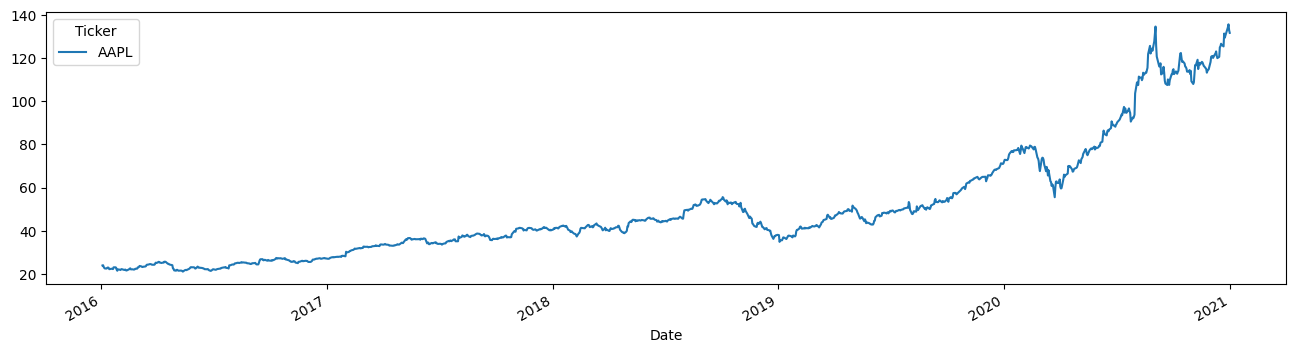

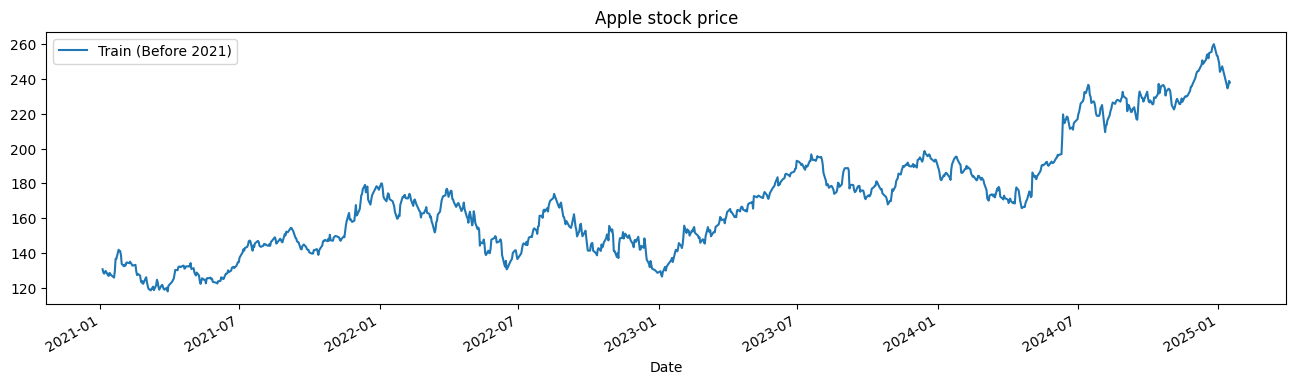

In [ ]:
train_test_plot(dataset, tstart, tend)


In [ ]:
# Define a function to split a dataset into training and test subsets based on time periods
def train_test_split(dataset, tstart, tend, columns=['High']):
    # Select data within the specified time range for training
    train = dataset.loc[f"{tstart}":f"{tend}", columns].values

    # Select data after the specified end year for testing
    test = dataset.loc[f"{tend+1}":, columns].values

    # Return the training and test subsets
    return train, test

In [ ]:
# Split the 'dataset' into training and test sets based on the 'tstart' and 'tend' time range
training_set, test_set = train_test_split(dataset, tstart, tend)

In [ ]:
# Create a Min-Max Scaler with the specified feature range
sc = MinMaxScaler(feature_range=(0, 1))

# Reshape the training set for compatibility with the scaler
training_set = training_set.reshape(-1, 1)

# Scale the training set data and store the scaled values in 'training_set_scaled'
training_set_scaled = sc.fit_transform(training_set)

In [ ]:
n_steps = 1      # Number of time steps in each sequence
features = 1     # Number of features in each time step

In [ ]:
# Define a function to split a sequence into input and output sequences for time series forecasting
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
# Split the scaled training set data into input sequences (X_train) and output sequences (y_train)
X_train, y_train = split_sequence(training_set_scaled, n_steps)

In [ ]:
# Reshape X_train to match the required input shape for the model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], features)

In [ ]:
# Define a function to plot real and predicted values for time series forecasting
def plot_predictions(test, predicted, title):
    # Plot the real values in gray
    plt.plot(test, color="gray", label="Real")

    # Plot the predicted values in red
    plt.plot(predicted, color="red", label="Predicted")

    # Set the title and labels for the plot
    plt.title(f'{title}')
    plt.xlabel("Time")
    plt.ylabel(f'{title}')

    # Add a legend to differentiate real and predicted values
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
# Define a function to calculate and print the root mean squared error (RMSE)
def return_rmse(test, predicted):
    # Calculate the RMSE using the mean_squared_error function from scikit-learn
    rmse = np.sqrt(mean_squared_error(test, predicted))

    # Print the RMSE
    print("The root mean squared error is {:.2f}.".format(rmse))

In [ ]:
# Define a function to plot the training loss over epochs
def plot_loss(history):
    # Create a figure with a specified size
    plt.figure(figsize=(15, 10))

    # Plot the training loss from the 'history' object
    plt.plot(history.history['loss'], label='loss')

    # Add a legend and display the plot
    plt.legend(loc='best')
    plt.show()

RNN

In [ ]:
# Create an RNN model for time series forecasting
model_rnn = Sequential()

# Add a SimpleRNN layer with 125 units and the specified input shape
model_rnn.add(SimpleRNN(units=125, input_shape=(n_steps, features)))

# Add a Dense layer with 1 unit for regression output
model_rnn.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the RNN model with the RMSprop optimizer and mean squared error (MSE) loss
model_rnn.compile(optimizer="RMSprop", loss="mse")

In [ ]:
# Fit the RNN model to the training data for 10 epochs, using a batch size of 32
# The training history is stored in the 'history' variable

history = model_rnn.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

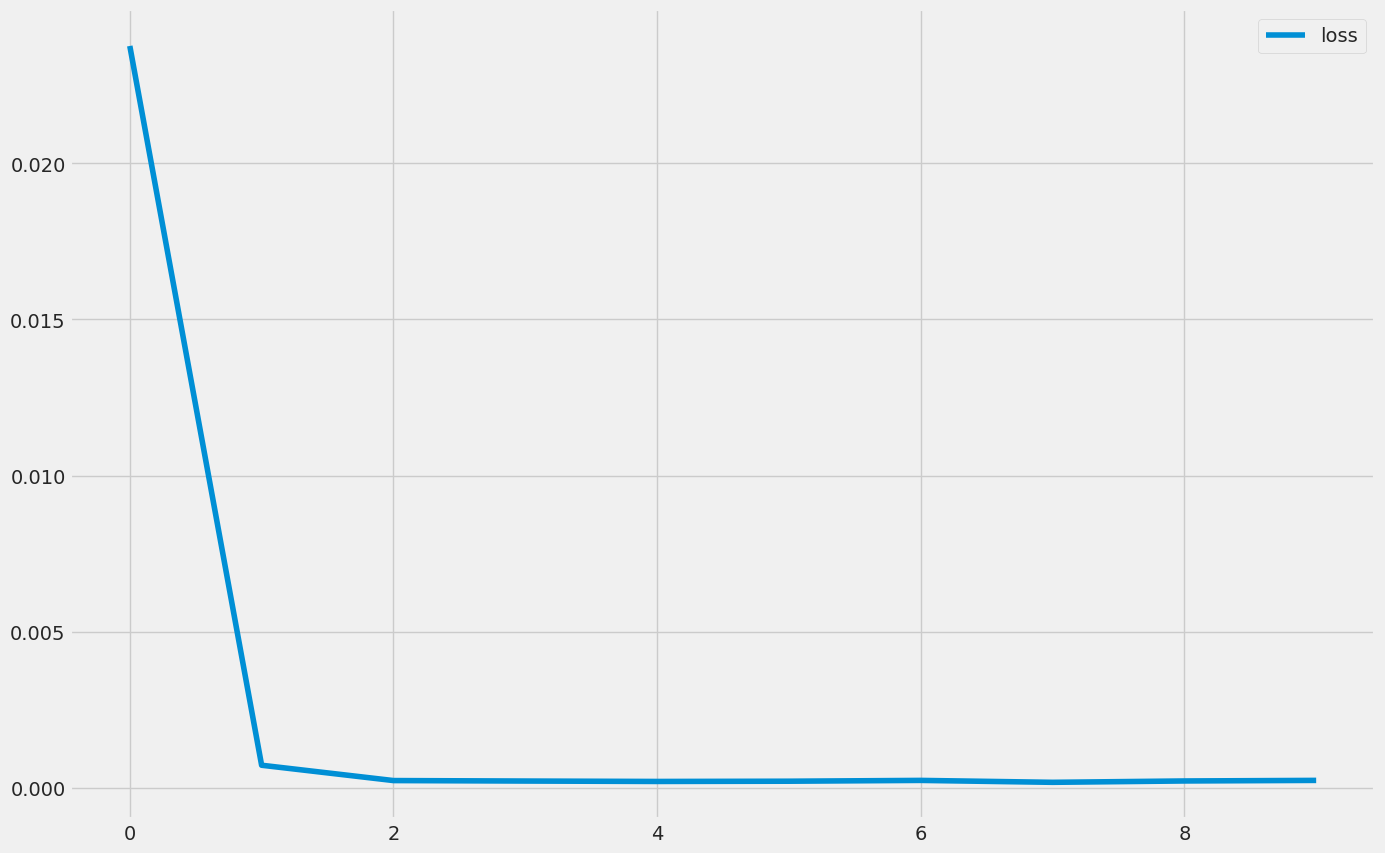

In [ ]:
plot_loss(history)

In [ ]:
# Scale the test data using the MinMaxScaler 'sc' previously fitted on the training data
inputs = sc.transform(test_set.reshape(-1, 1))

In [ ]:
# Split the scaled test data into input samples and target values
X_test, y_test = split_sequence(inputs, n_steps)

# Reshape the input samples to match the model's input shape
X_test = X_test.reshape(-1, n_steps, features)

In [ ]:
# Use the trained RNN model to make predictions on the test data
predicted_stock_price = model_rnn.predict(X_test)

# Inverse transform the predicted values to their original scale
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


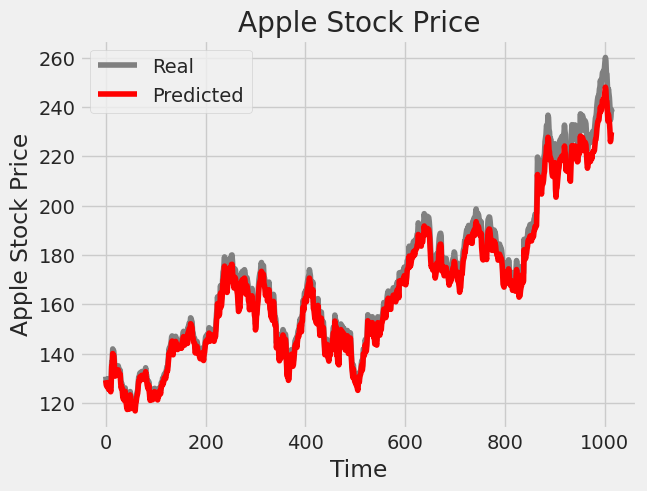

In [ ]:
# Plot the real stock prices (test_set) and the predicted stock prices for Apple
plot_predictions(test_set, predicted_stock_price, "Apple Stock Price")

In [ ]:
steps_in_future = 25

In [ ]:
def sequence_generation(dataset: pd.DataFrame, sc: MinMaxScaler, model: Sequential, steps_future: int):
    # Extract the 'High' column
    high_dataset = dataset.iloc[len(dataset) - len(test_set) - n_steps:]["High"]

    # Scale the 'High' column using the MinMaxScaler
    high_dataset = sc.transform(high_dataset.values.reshape(-1, 1))

    # Initialize the inputs with the first n_steps values of the scaled 'High' dataset
    inputs = high_dataset[:n_steps]

    # Generate predictions for steps_future time steps into the future
    for _ in range(steps_future):
        # Predict the next value based on the previous n_steps values using the model
        curr_pred = model.predict(inputs[-n_steps:].reshape(-1, n_steps, features), verbose=0)

        # Append the predicted value to the inputs for the next iteration
        inputs = np.append(inputs, curr_pred, axis=0)

    # Inverse transform the scaled values to obtain the final predicted values
    return sc.inverse_transform(inputs[n_steps:])

In [ ]:
# Using sequence_generation function to generate a sequence of future values
results = sequence_generation(dataset, sc, model_rnn, steps_in_future)

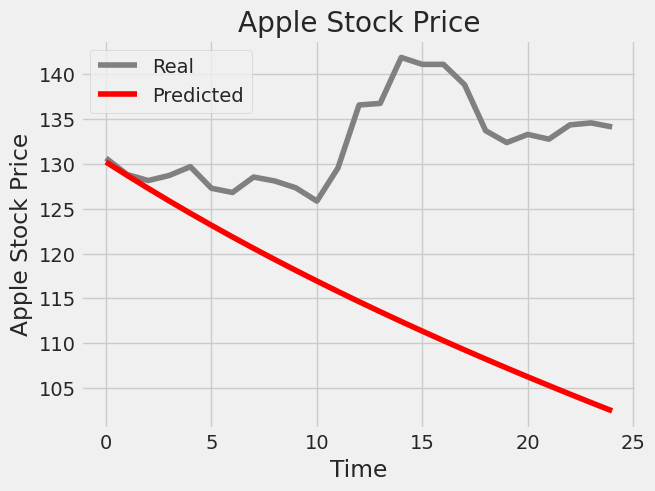

In [ ]:
# Visualize the predicted values against the actual test data for "Apple Stock Price"
plot_predictions(test_set[:steps_in_future], results, "Apple Stock Price")

LSTM


In [ ]:
# Create a Sequential model
model_lstm = Sequential()

# Add an LSTM layer with 125 units and specify the input shape
model_lstm.add(LSTM(units=125, input_shape=(n_steps, features)))

# Add a Dense layer with 1 unit for the final output
model_lstm.add(Dense(units=1))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model using the RMSprop optimizer and (MSE) as the loss function
model_lstm.compile(optimizer="RMSprop", loss="mse")

In [ ]:
# Fit the model using the training data
history = model_lstm.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

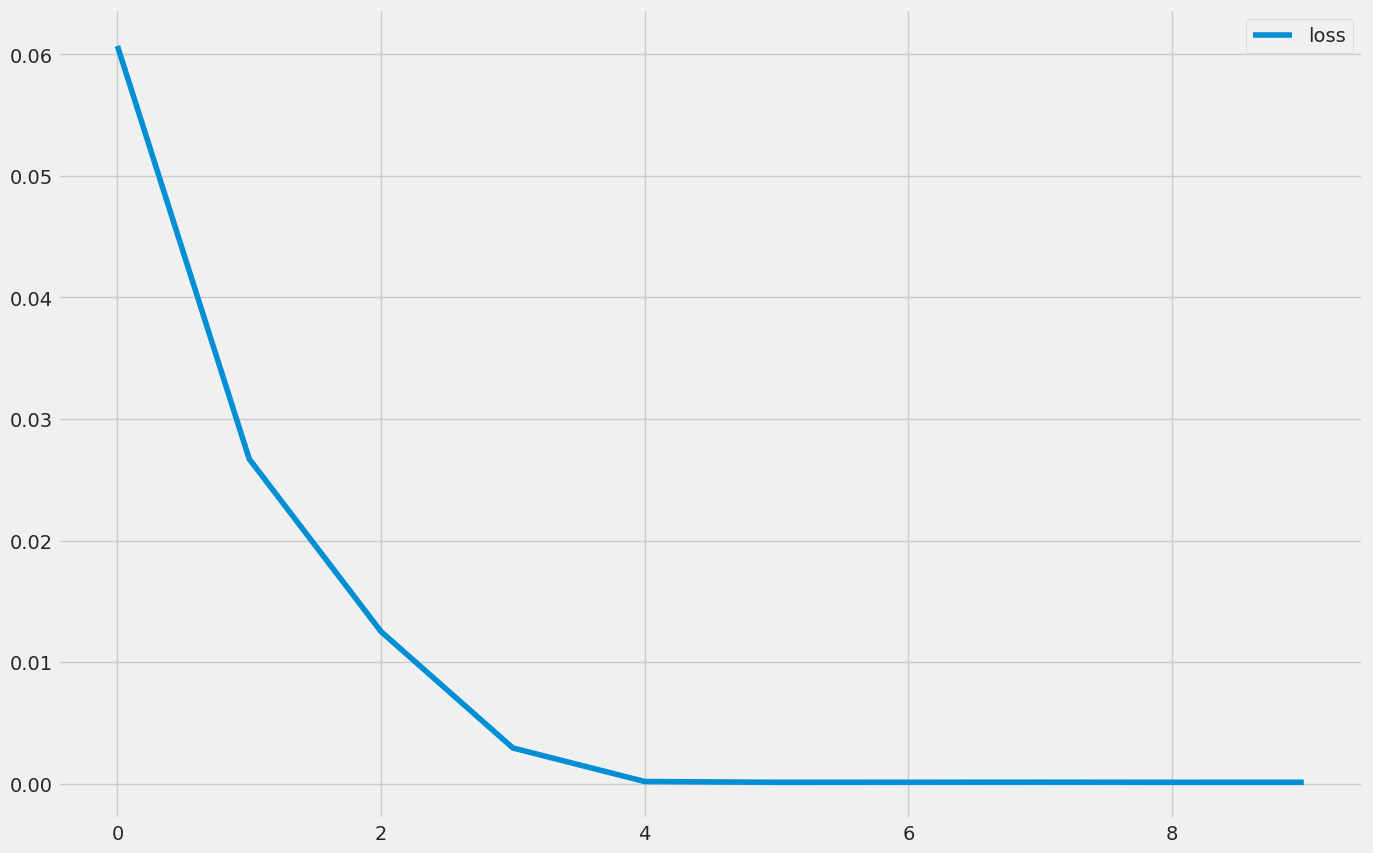

In [ ]:
plot_loss(history)

In [ ]:
# Make predictions on the test data using the trained model
predicted_stock_price = model_lstm.predict(X_test)

# Inverse transform the scaled predictions to obtain the original values
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


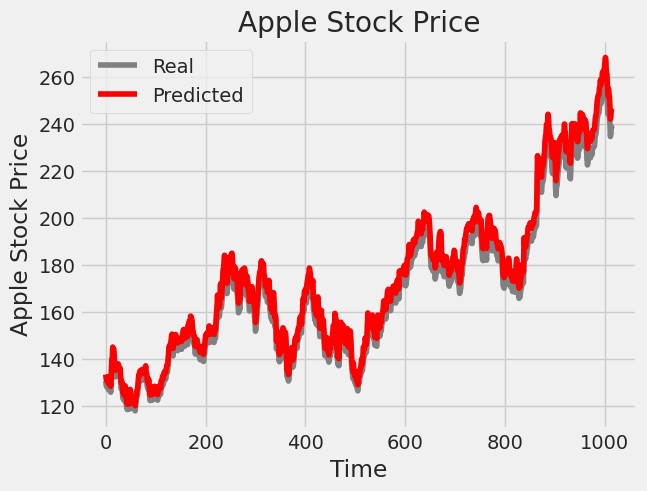

In [ ]:
# Visualize the predicted values against the actual test data for "Apple Stock Price"
plot_predictions(test_set, predicted_stock_price, "Apple Stock Price")